In [66]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier

import gc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


In [68]:
# Load the annotations file
anno = pd.read_csv('data/annotations.csv')

In [70]:
# Function to extract MFCCs from an audio file
def extract_mfccs(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

In [72]:
# Extract features and labels
features = np.array([extract_mfccs(f'data/audio/{row["filename"]}') for index, row in anno.iterrows()])
labels = anno['context'].values

In [74]:
# Standardise features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [76]:
# Define models and hyperparameters
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),  
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, activation='relu', solver='adam', early_stopping=True) 
}

param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20]
    },
    'Support Vector Machine': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__activation': ['relu'],
        'model__solver': ['adam'],
        'model__alpha': [0.0001, 0.05],
        'model__learning_rate': ['constant']
    }
}


In [78]:
# Prepare for nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=inner_cv, scoring='accuracy')
    nested_cv_scores = cross_val_score(grid_search, features_scaled, labels_encoded, cv=outer_cv, scoring='accuracy')
    
    results.append((name, nested_cv_scores))


In [80]:
# Print results to check structure
print(results)

[('Random Forest', array([0.79136691, 0.76258993, 0.84172662, 0.77536232, 0.82608696])), ('Support Vector Machine', array([0.82733813, 0.77697842, 0.86330935, 0.86956522, 0.83333333])), ('MLP', array([0.69784173, 0.63309353, 0.77697842, 0.69565217, 0.77536232]))]


In [82]:
# Convert results to a DataFrame
results_df = pd.DataFrame({
    'Model': [name for name, _ in results],
    'Mean Accuracy': [scores.mean() for name, scores in results],
    'Std Accuracy': [scores.std() for name, scores in results]
})

# Print results
print(results_df)


                    Model  Mean Accuracy  Std Accuracy
0           Random Forest       0.799427      0.030004
1  Support Vector Machine       0.834105      0.032925
2                     MLP       0.715786      0.054515


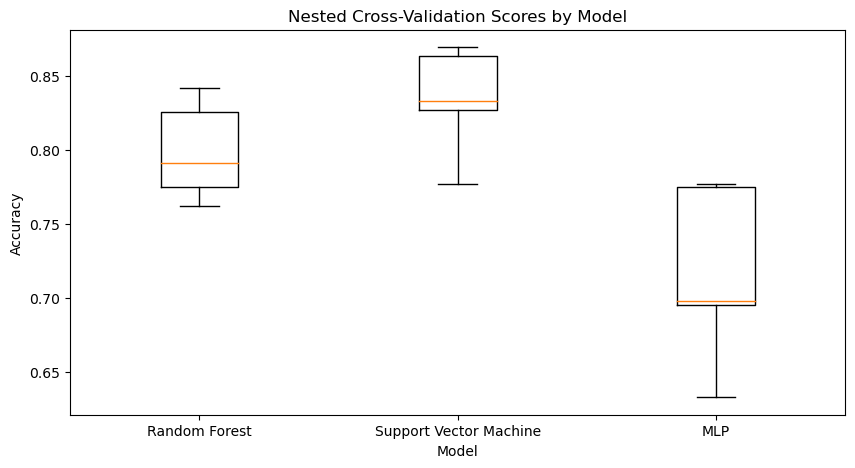

In [84]:
# Plot results
plt.figure(figsize=(10, 5))
plt.boxplot([scores for _, scores in results], labels=[name for name, _ in results])
plt.title('Nested Cross-Validation Scores by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [86]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

In [88]:
# Select the best model based on cross-validation
best_model_name = results_df.loc[results_df['Mean Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]
pipeline = Pipeline([('scaler', StandardScaler()), ('model', best_model)])
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[best_model_name], cv=inner_cv, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model.set_params(**{k.split('__')[1]: v for k, v in best_params.items()})


SVC(C=10, probability=True)

In [90]:
# Evaluate the best model
metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test)

# Print evaluation metrics
for dataset, metric_values in metrics.items():
    print(f"{dataset} metrics:")
    for metric, value in metric_values.items():
        print(f"  {metric}: {value:.4f}")

Train metrics:
  Accuracy: 0.9440
  Precision: 0.9449
  Recall: 0.9440
  F1 Score: 0.9433
Test metrics:
  Accuracy: 0.8489
  Precision: 0.8553
  Recall: 0.8489
  F1 Score: 0.8474


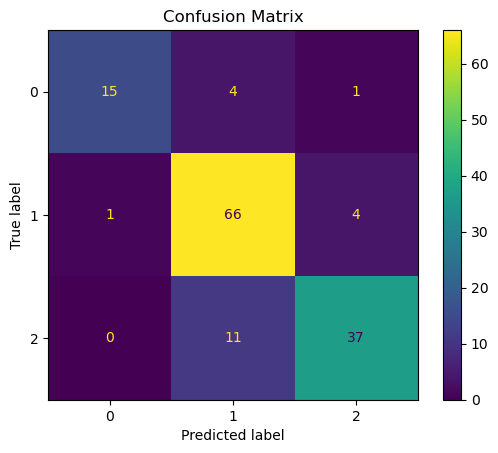

In [92]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

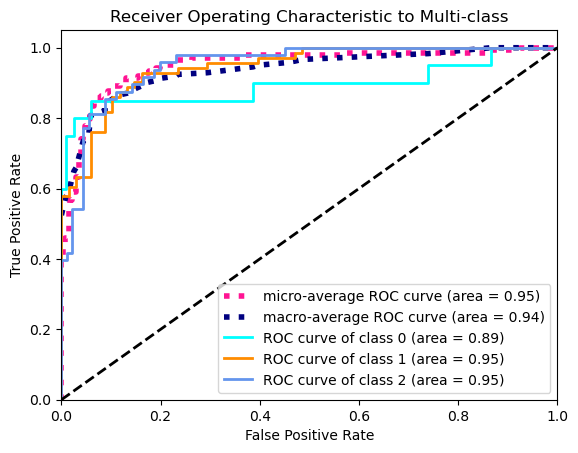

In [94]:
# Plot ROC Curves
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]
y_score = best_model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot 
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.show()

In [96]:
# Check Labels
class_labels = label_encoder.classes_
print(class_labels)


['aggression' 'contact' 'play']
